In [1]:
from collections import deque
from enum import Enum
from itertools import islice


class VirusStatesBase(Enum):
    def __init__(self, next_, rotation):
        self._next = next_
        self.rotation = rotation
    
    @property
    def next(self):
        return type(self)[self._next]
    
    def __repr__(self):
        return f'{type(self).__name__}.{self.name}'


class VirusStates(VirusStatesBase):    
    CLEAN = 'INFECTED', 1
    INFECTED = 'CLEAN', -1


class VirusGrid:
    def __init__(self, infected, states):
        self.states = states
        self.infected = dict.fromkeys(infected, states.INFECTED)
        self.directions = deque([(0, -1), (1, 0), (0, 1), (-1, 0)])
        self.pos = 0, 0

    @classmethod
    def from_lines(cls, lines, states=VirusStates):
        # assumption: grid is square
        infected = set()
        halfsize = None
        for row, line in enumerate(lines):
            line = line.strip()
            if halfsize is None:
                halfsize = len(line) // 2
            y = row - halfsize
            infected.update(
                (x, y) for x, f in enumerate(line, -halfsize)
                if f == '#')
        return cls(infected, states)
    
    def __iter__(self):
        return self
    
    def __next__(self):
        state = self.infected.get(self.pos, self.states.CLEAN)
        self.directions.rotate(state.rotation)
        next_state = state.next
        if next_state is self.states.CLEAN:
            del self.infected[self.pos]
        else:
            self.infected[self.pos] = next_state
        dx, dy = self.directions[0]
        self.pos = self.pos[0] + dx, self.pos[1] + dy
        return state.next


class EvolvedVirusStates(VirusStatesBase):
    # value is next state and directions rotation
    CLEAN = 'WEAKENED', 1
    WEAKENED = 'INFECTED', 0
    INFECTED = 'FLAGGED', -1
    FLAGGED = 'CLEAN', 2

In [2]:
test_grid_1 = VirusGrid.from_lines('''\
..#
#..
...'''.splitlines())
assert sum(state is VirusStates.INFECTED for state in islice(test_grid_1, 10000)) == 5587

In [3]:
with open('inputs/day22.txt') as day22:
    grid_1 = VirusGrid.from_lines(day22)

print('Part 1:', sum(state is VirusStates.INFECTED for state in islice(grid_1, 10000)))

Part 1: 5411


In [4]:
test_grid_2 = VirusGrid.from_lines('''\
..#
#..
...'''.splitlines(), EvolvedVirusStates)
assert sum(state is EvolvedVirusStates.INFECTED for state in islice(test_grid_2, 10000000)) == 2511944

In [5]:
with open('inputs/day22.txt') as day22:
    grid_2 = VirusGrid.from_lines(day22, EvolvedVirusStates)

print('Part 2:', sum(state is EvolvedVirusStates.INFECTED for state in islice(grid_2, 10000000)))

Part 2: 2511416


In [138]:
def bounds(infected):
    x_min, x_max = min(x for x, y in infected), max(x for x, y in infected)
    y_min, y_max = min(y for x, y in infected), max(y for x, y in infected)
    return x_min, x_max + 1, y_min, y_max + 1

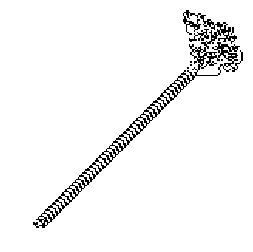

In [88]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

bbox = bounds(grid_1.infected)
image = np.array([[(x, y) in grid_1.infected for x in range(*bbox[:2])] for y in range(*bbox[2:])])
plt.axis('off')
plt.imshow(image, cmap=plt.get_cmap('Greys'))

In [103]:
from matplotlib import animation, rc
from functools import partial
from IPython.core.debugger import set_trace

rc('animation', html='html5')


def array(grid, bbox, map_, states=VirusStates):
    return np.array(
        [[map_[grid.infected.get((x, y), states.CLEAN)]
          for x in range(*bbox[:2])]
         for y in range(*bbox[2:])])


def render(count, image, grid, map_, steps=10):
    data = image.get_array()
    for _ in range(steps):
        x, y = grid.pos
        state = next(grid)
        # normalise to 0 - max ranges
        x -= bbox[0]
        y -= bbox[2]
        data[y, x] = map_[state]
    return image,

The animations produced below can be viewed online [via the Jupyter notebook viewer](https://nbviewer.jupyter.org/github/mjpieters/adventofcode/blob/master/2017/Day%2022.ipynb); the GitHub renderer filters them out.

In [105]:
with open('inputs/day22.txt') as day22:
    grid_1_anim = VirusGrid.from_lines(day22)    

map_ = {VirusStates.CLEAN: False, VirusStates.INFECTED: True}

fig = plt.figure()
image = plt.imshow(
    array(grid_1_anim, bbox, map_),
    cmap='Greys', animated=True)
plt.axis('off')
plt.close(fig)

animation.FuncAnimation(
    fig, render, 1000,
    fargs=(image, grid_1_anim, map_),
    interval=5, blit=True, repeat_delay=5000)

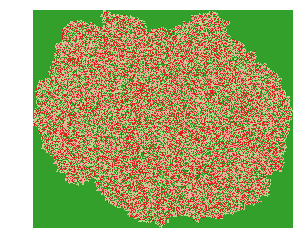

In [141]:
bbox = bounds(grid_2.infected)

map_ = {
    EvolvedVirusStates.CLEAN: 3,
    EvolvedVirusStates.WEAKENED: 2,
    EvolvedVirusStates.INFECTED: 5,
    EvolvedVirusStates.FLAGGED: 4,
}

image = np.array([[map_[grid_2.infected.get((x, y), EvolvedVirusStates.CLEAN)] for x in range(*bbox[:2])] for y in range(*bbox[2:])])

plt.imshow(image, cmap='Paired', vmin=0, vmax=12)
_ = plt.axis('off')

In [145]:
with open('inputs/day22.txt') as day22:
    grid_2_anim = VirusGrid.from_lines(day22, EvolvedVirusStates)  

margin = 2  # the blob exands a little before settling on the final bounds
bbox = [bbox[0] - margin, bbox[1] + margin, bbox[2] - margin, bbox[3] + margin]

fig = plt.figure()
image = plt.imshow(
    array(grid_2_anim, bbox, map_, EvolvedVirusStates),
    cmap='Paired', vmin=0, vmax=12,
    animated=True)
plt.axis('off')
plt.close(fig)

animation.FuncAnimation(
    fig, render, 2000,
    fargs=(image, grid_2_anim, map_, 5000),
    interval=5, blit=True, repeat_delay=5000)